# Modelo con 75% de Pt, 25% Ni, distribución radial aleatoria tipo $x^n$
## Empezamos por hacer nuestro shell
Creamos nuestro Shell FCC de 10 capas, distancia interatómica de 2.78 Angstroms, con 75% de Pt y 25% de Ni. Hacemos un radcut de 15 A, y de igual manera lo visualizamos con jmol

In [2]:
from sys import path
import os
dir_actual = os.getcwd()
path.insert(0, 'C:/Users/guill/OneDrive/Documentos/Tesis/Proyect')

import myfuncions.core_shell_f as cs
import myfuncions.randomize_f as ranf
import myfuncions.tools_f as tools
import subprocess as sbp

coords = cs.cubeShell(10,2.775,'fcc')
coords = cs.sphericalShave(coords,15)
atpos, eleList = cs.atpos_eleList_maker(coords,'Ni')

porcentajes = {'Pt':0.75, 'Ni':0.25}

atpos, eleList, mode = ranf.pow_rad_ch(atpos, eleList, porcentajes,30)
print(mode)
tools.show_percent(atpos,eleList)

name='Pt-0.75-radrand.xyz'
tools.wXYZ(atpos,name)

sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', name])

Cambia en potencia el porcentaje radial de átomos en {'Pt': 0.75, 'Ni': 0.25}
pow
atomos totales : 959
Ni : 27.528675703858184 %, 264
Pt : 72.47132429614182 %, 695


CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'Pt-0.75-radrand.xyz'], returncode=0)

Este es el modelo

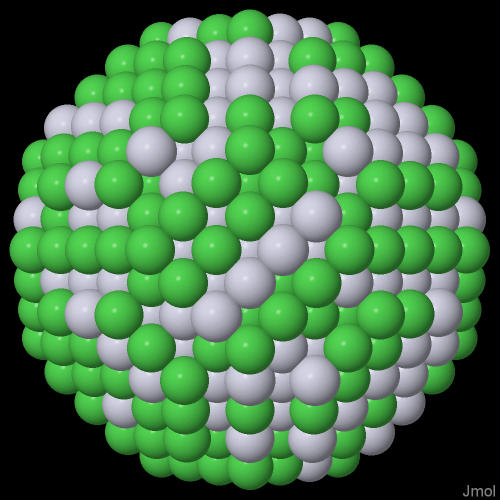

## Hacemos el archivo de coordenadas con lammpin

In [3]:
from myfuncions.lammpin_f import wlammpin

wlammpin(atpos,eleList,name)

Pt-0.75-radrand.ini


## Dinámica Molecular empieza aquí
Consiste de 600 pasos de rescale a 0K, 3000 de rampa con berensen a 300K y 1000 de termalización a 300K con lavgevin.

In [4]:

input = f"""
# 2NN EAM potential in LAMMPS

 units		metal
 atom_style	atomic
 boundary	f f f

 read_data	{name[:-4]}.ini
 pair_style	meam
 pair_coeff	* * ..\\..\\LAMMPS\\library.meam Pt Ni ..\\..\\LAMMPS\\PtNiV2.pot Pt Ni 
 
 neighbor	0.5 bin
 neigh_modify	every 1 delay 0 check yes once no
 velocity	all create 0.00 13478 rot yes mom yes dist gaussian
 timestep	0.005

 fix            1 all nve
 fix            2 all temp/rescale 10 0.00 0.00 1.0 1
 thermo         100
 thermo_style   custom step temp atoms pe ke etotal
 thermo_modify  lost ignore
 run 600

 unfix 2
 fix         3 all temp/berendsen 0.0 300.0 0.1
 thermo		100
 run		3000

 unfix 3
 timestep   0.001
 thermo		100
 fix		4 all langevin 300.0 300.0 0.5 87654
 dump           4 all xyz 100 {name[:-4]}_d.xyz
 run		1000
"""
with open('input.in','w') as archivo:
    archivo.write(input)

os.system('start powershell -Command lmp -in input.in; Start-Sleep -s 5; exit')

0

## Ahora hacemos el análisis de distribución del dump
La siguiente función cuenta los atomos que hay entr $r$ y $r+\Delta r$, lo ideal es darle un $\Delta r \approx$ radio atómico del atomo de interés (1.4 $\AA$ para el Pt), aquí también se cambian las etiquetas en atpos, $\Delta r$ puede ser cualquier valor sin embargo he encontrado que se obtienen mejores resultados así

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Cambia etiquetas a "atpos"
jala


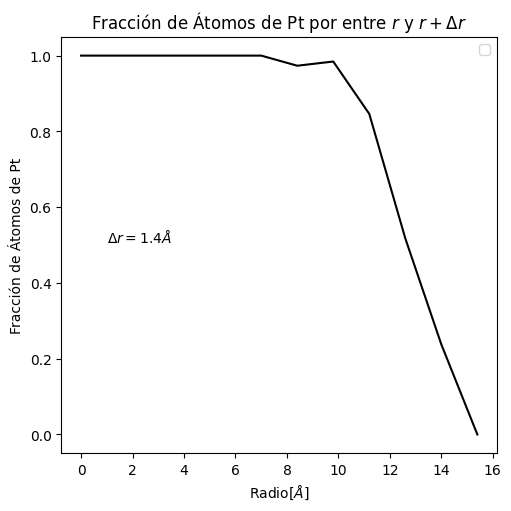

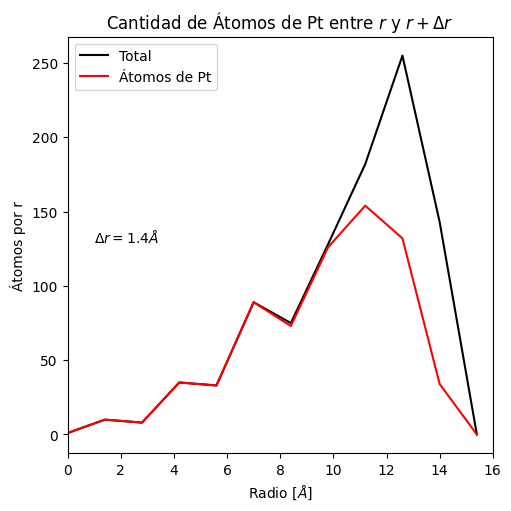

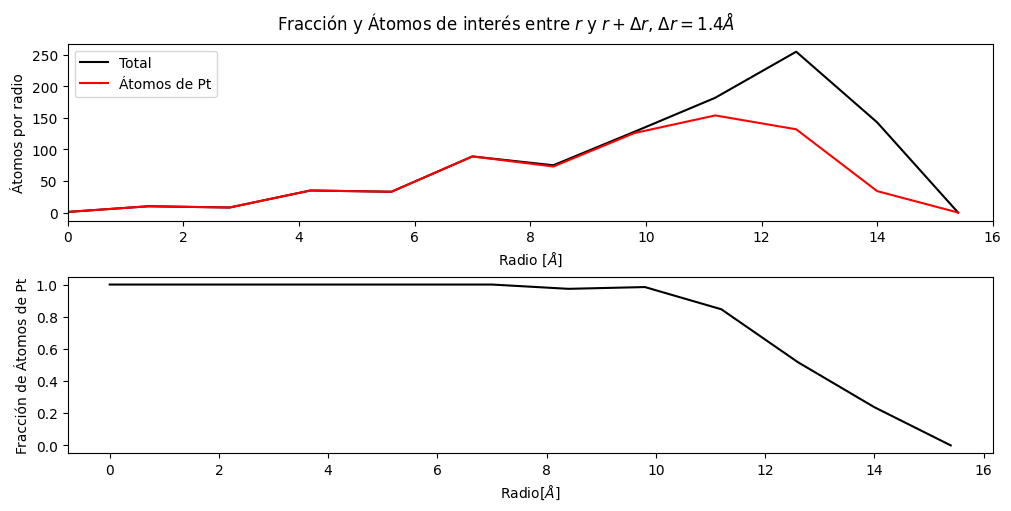

In [5]:
import myfuncions.graphs_f as gf
datpos, deleList = tools.leer_xyz(f'{name[:-4]}_d.xyz')
datpos, deleList = tools.cambiar_etiquetas_xyz(datpos, deleList, {1: 'Ni', 2: 'Pt'})

gf.dump_graficar_fracc_atpr(datpos,'Pt',1.4)
gf.dump_graficar_atpr(datpos,'Pt',1.4)
gf.plot_dump_f_y_atpr(datpos,'Pt',1.4)

Las mismas graficas pero con $\Delta r = 0.2 \AA$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


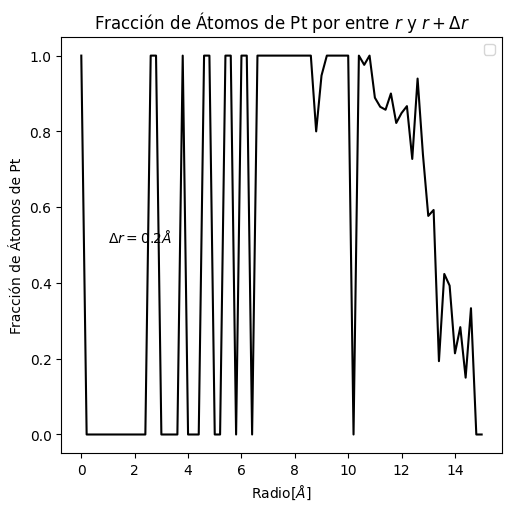

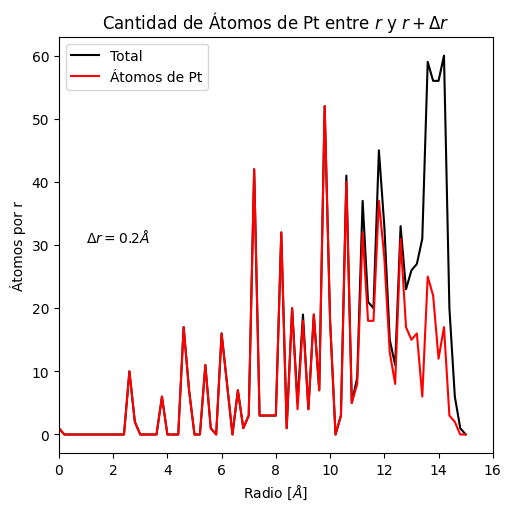

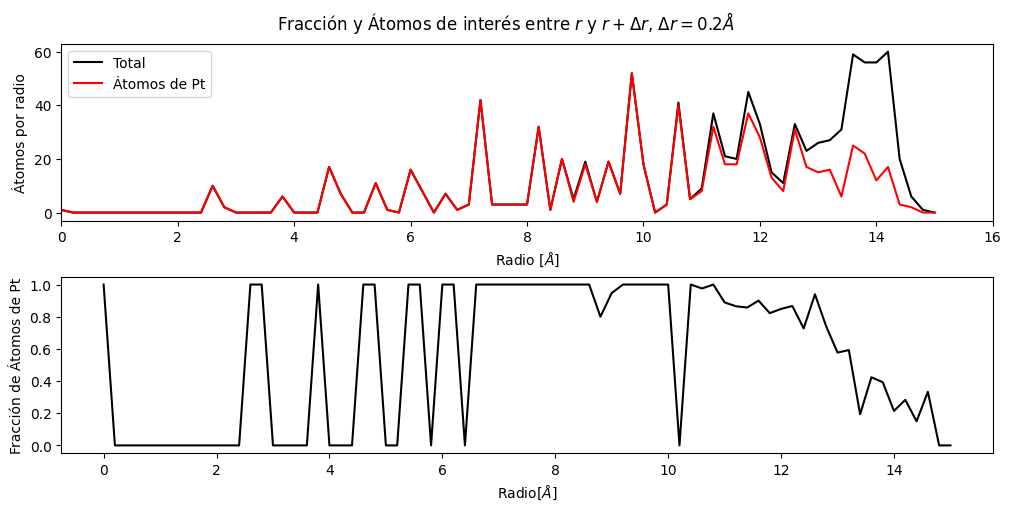

In [29]:
gf.dump_graficar_fracc_atpr(datpos,'Pt',0.2)
gf.dump_graficar_atpr(datpos,'Pt',0.2)
gf.plot_dump_f_y_atpr(datpos,'Pt',0.2)

## Modelo de dump
Se reescribe el .xyz con las nuevas etiquetas para visualizarlo

In [6]:
tools.wXYZ(datpos,f'{name[:-4]}_d.xyz')

sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', f'{name[:-4]}_d.xyz'])

CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'Pt-0.75-radrand_d.xyz'], returncode=0)

Este es el dump:


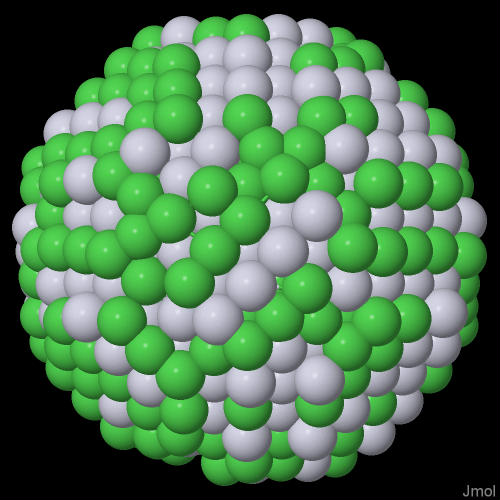
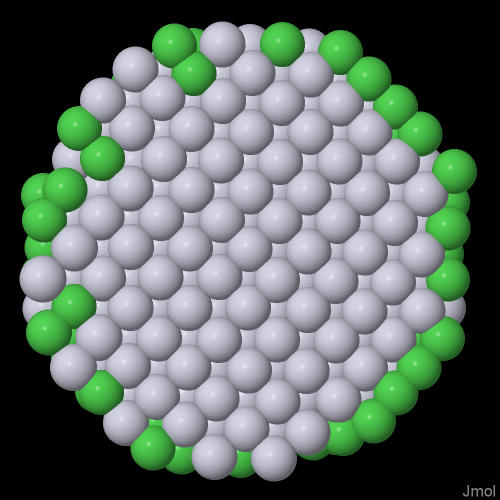

## Aquí se hace el PDF y la gráfica

In [12]:
import PDF.runner as pdf
pdf.run_pdf(f'{name[:-4]}_d.xyz', dir_actual, 1600,0.02)

c:\Users\guill\OneDrive\Documentos\Tesis\Proyect\15_de_marzo\Pt_75_radrand

         959  atomos       459361  pares 
 Rango de distancias    2.15954089     -   29.2886715    
 Distancias promedio    15.3735437    
 Factor de normalizacion    36421.1055    



Hacemos la gráfica PDF y comparamos con un modelo que tiene MD de Pt 100%

In [26]:
Ni =int(porcentajes['Ni']*100)
Pt = int(porcentajes['Pt']*100)

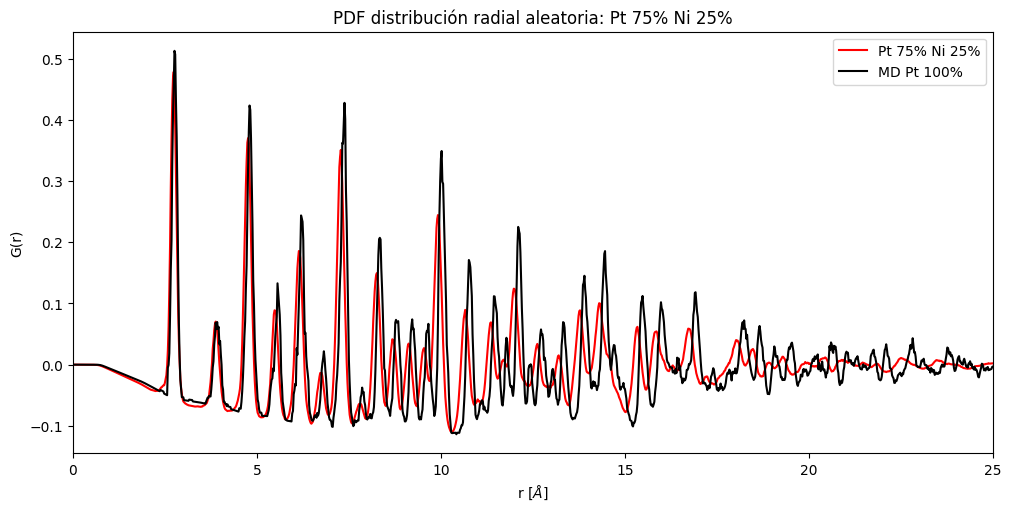

In [27]:
import pandas as pd
import matplotlib.pyplot as plt


df_FCC= pd.read_csv(f'{name[:-4]}_d.txt', sep='\s+')
df_ref = pd.read_csv('C:/Users/guill/OneDrive/Documentos/Tesis/Proyect/15_de_marzo/Pt_100/Pt-FCC_d.txt', sep = '\s+')


fig, ax =plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(df_FCC['#r(A)'], df_FCC['G(r)'], label=f'Pt {Pt}% Ni {Ni}%', color = 'red')
ax.plot(df_ref['#r(A)'],df_ref['G(r)'], label = 'MD Pt 100%', color = 'black')


ax.set_xlabel('r [$\\AA$]')
ax.set_xlim([0,25])
ax.set_ylabel('G(r)')
ax.set_title(f'PDF distribución radial aleatoria: Pt {Pt}% Ni {Ni}%')
#ax.grid('True', linestyle='-')
ax.legend()
plt.show()

Ahora hacemos una gráfica comparando con un modelo de Ni 100% que tiene MD

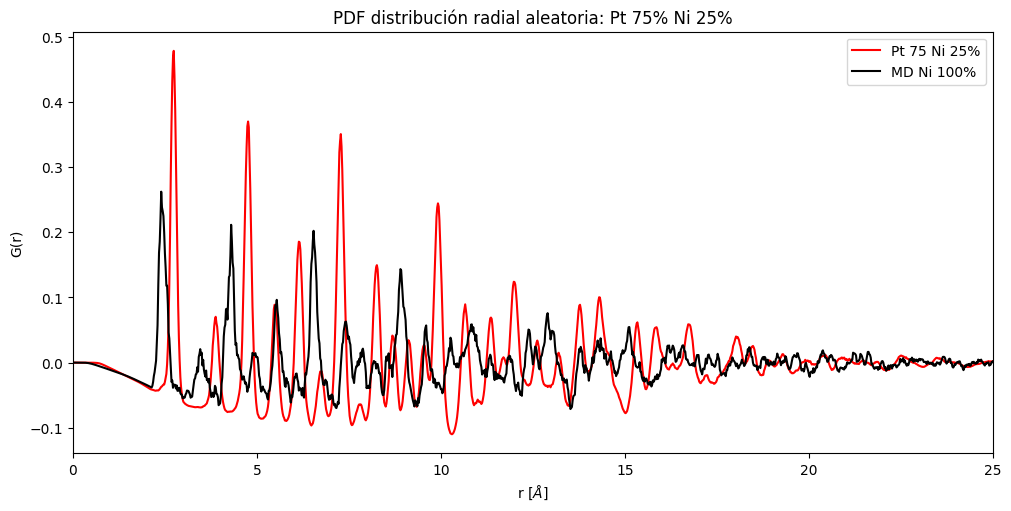

In [28]:
df_FCC= pd.read_csv(f'{name[:-4]}_d.txt', sep='\s+')
df_ref = pd.read_csv('C:/Users/guill/OneDrive/Documentos/Tesis/Proyect/15_de_marzo/Ni_100/Ni-FCC_d.txt', sep = '\s+')


fig, ax =plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(df_FCC['#r(A)'], df_FCC['G(r)'], label=f'Pt {Pt} Ni {Ni}%', color = 'red')
ax.plot(df_ref['#r(A)'],df_ref['G(r)'], label = 'MD Ni 100%', color = 'black')


ax.set_xlabel('r [$\\AA$]')
ax.set_xlim([0,25])
ax.set_ylabel('G(r)')
ax.set_title(f'PDF distribución radial aleatoria: Pt {Pt}% Ni {Ni}%')
#ax.grid('True', linestyle='-')
ax.legend()
plt.show()